<a href="https://colab.research.google.com/github/liulalemx/TA-and-NLP-/blob/main/Politik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Politik - Political Leaning Estimator

In [6]:
!pip install --upgrade transformers datasets accelerate pyarrow numpy

In [5]:
!pip install evaluate

In [4]:
import os
import re
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

# Transformers imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from evaluate import load
import numpy as np


In [7]:
def setup_nltk():
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)

setup_nltk()
stop_words = set(stopwords.words('english'))

# Data Loading and Cleaning

In [8]:
# --- Text-cleaning ---
def clean_text(html_text):
    text = BeautifulSoup(html_text, 'html.parser').get_text()
    text = text.lower().strip()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-z0-9\s]", ' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [9]:
# --- Load data ---
# Political Bias Data
csv_path = 'political_bias.csv'
df = pd.read_csv(csv_path)
df.rename(columns={'text': 'content', 'label': 'label'}, inplace=True)
df.dropna(subset=['content', 'label'], inplace=True)
df['cleaned_content'] = df['content'].astype(str).apply(clean_text)

# Generated Data
csv_path2 = 'generated_posts.csv'
df_gen = pd.read_csv(csv_path2)
df_gen.rename(columns={'text': 'content', 'label': 'label'}, inplace=True)
df_gen.dropna(subset=['content', 'label'], inplace=True)
df_gen['cleaned_content'] = df_gen['content'].astype(str).apply(clean_text)

merged_df = pd.concat([df, df_gen], ignore_index=True)


In [10]:
merged_df[["content", "cleaned_content"]].head()

,content,cleaned_content
0,The government should reduce taxes significant...,government reduce taxes significantly stimulat...
1,Cutting welfare programs is necessary to encou...,cutting welfare programs necessary encourage p...
2,A strong military is essential for national se...,strong military essential national security pr...
3,Deregulation is crucial to promote free market...,deregulation crucial promote free market compe...
4,Traditional family values should be upheld to ...,traditional family values upheld maintain soci...


# EDA

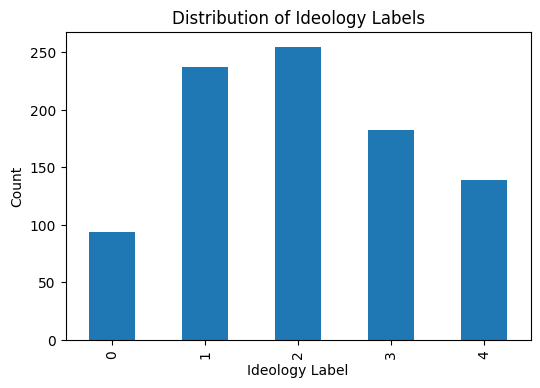

In [11]:
label_counts = merged_df['label'].value_counts().sort_index()
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar')
plt.xlabel('Ideology Label')
plt.ylabel('Count')
plt.title('Distribution of Ideology Labels')
plt.show()

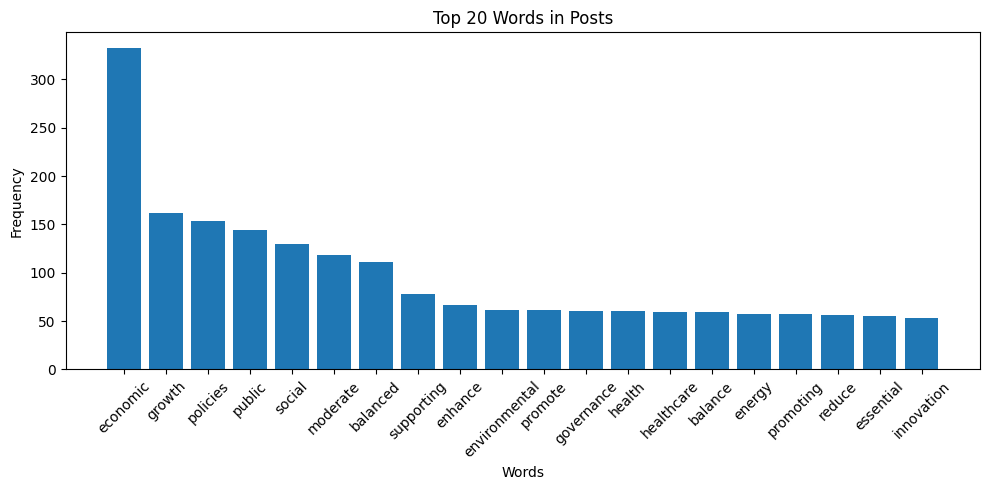

In [12]:
from collections import Counter
def plot_word_frequency(clean_texts, top_n=20):
    # Combine all texts into one list of words
    all_words = []
    for text in clean_texts:
        all_words.extend(text.split())

    # Count the frequency of each word
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(top_n)

    # Unzip the list of tuples into two lists
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(f'Top {top_n} Words in Posts')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot word frequency using the 'cleaned_content' column
plot_word_frequency(merged_df['cleaned_content'].tolist())


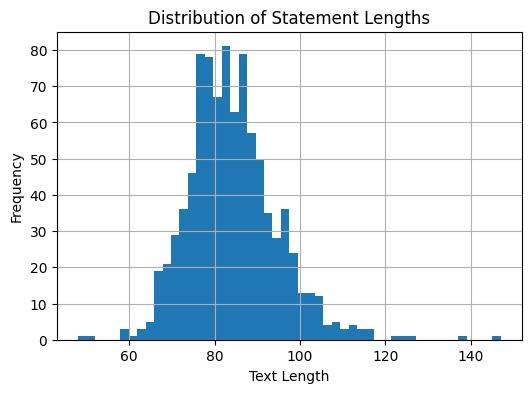

In [13]:
merged_df['text_length'] = merged_df['content'].str.len()
plt.figure(figsize=(6,4))
merged_df['text_length'].hist(bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Statement Lengths')
plt.show()

# Sentiment Analysis

In [14]:
# --- VADER Sentiment Scoring ---
vader = SentimentIntensityAnalyzer()
vader_scores = merged_df['cleaned_content'].apply(vader.polarity_scores)
merged_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = pd.DataFrame(vader_scores.tolist(), index=merged_df.index)
merged_df[["cleaned_content", "vader_neg", "vader_neu", "vader_pos", "vader_compound"]].head()

,cleaned_content,vader_neg,vader_neu,vader_pos,vader_compound
0,government reduce taxes significantly stimulat...,0.000,0.522,0.478,0.6597
1,cutting welfare programs necessary encourage p...,0.117,0.625,0.258,0.4215
2,strong military essential national security pr...,0.000,0.280,0.720,0.8519
3,deregulation crucial promote free market compe...,0.000,0.320,0.680,0.8176
4,traditional family values upheld maintain soci...,0.000,0.722,0.278,0.4019


In [15]:
# --- Categorize VADER sentiment ---
def categorize_vader(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'
merged_df['vader_sentiment'] = merged_df['vader_compound'].apply(categorize_vader)

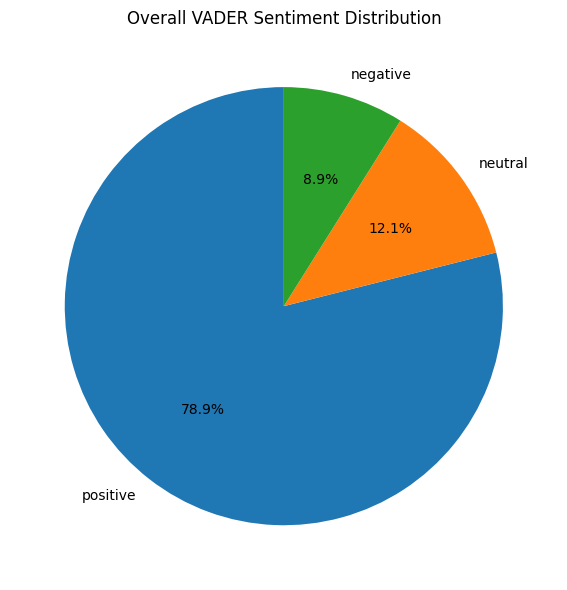

In [16]:
# --- VADER Distribution & Top Posts ---
# Pie chart of VADER sentiment categories
total_counts = merged_df['vader_sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    total_counts,
    labels=total_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Overall VADER Sentiment Distribution')
plt.tight_layout()
plt.show()

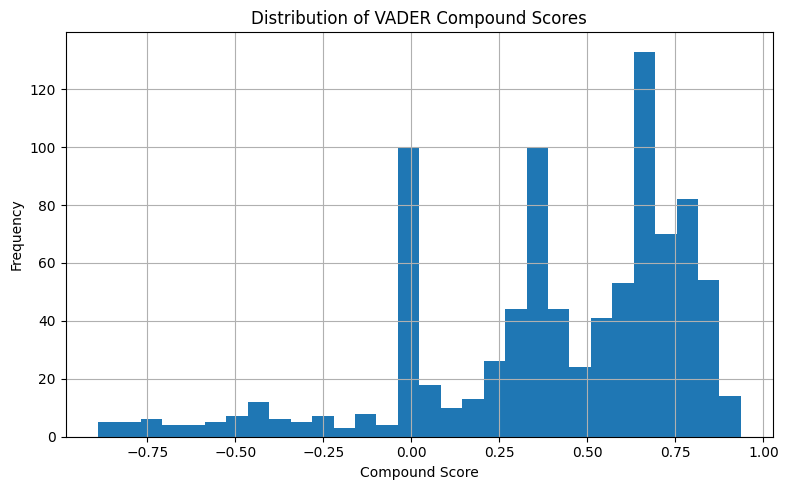

In [17]:
# Histogram of compound scores
merged_df['vader_compound'].hist(bins=30, figsize=(8,5))
plt.title('Distribution of VADER Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Top 5 most positive posts by VADER
print("Top 5 Most Positive Posts (VADER):")
top_positive = merged_df.nlargest(5, 'vader_compound')[['content', 'vader_compound']]
for idx, row in top_positive.iterrows():
    print(f"Score: {row.vader_compound:.3f} | Text: {row.content}\n")

Top 5 Most Positive Posts (VADER):
Score: 0.936 | Text: A free market economy is the best way to ensure economic growth and innovation.

Score: 0.922 | Text: Free and fair trade benefits all nations involved, promoting peace and prosperity.

Score: 0.900 | Text: Strengthening civil liberties protections is crucial for ensuring equality and justice.

Score: 0.900 | Text: Supporting clean energy research can boost economic growth and environmental sustainability.

Score: 0.900 | Text: Supporting clean energy research can boost both economic and environmental benefits.



In [ ]:
# Top 5 most negative posts by VADER
print("Top 5 Most Negative Posts (VADER):")
top_negative = merged_df.nsmallest(5, 'vader_compound')[['content', 'vader_compound']]
for idx, row in top_negative.iterrows():
    print(f"Score: {row.vader_compound:.3f} | Text: {row.content}\n")

Top 5 Most Negative Posts (VADER):
Score: -0.891 | Text: Regulations aimed at combating climate change are an unacceptable burden on businesses and kill jobs.

Score: -0.878 | Text: The opioid crisis was fueled by corporate greed and regulatory failure.

Score: -0.859 | Text: We have a moral obligation to provide humanitarian aid to countries suffering from disaster or conflict.

Score: -0.856 | Text: Comprehensive gun safety laws, including bans on assault weapons, are needed to reduce violence.

Score: -0.852 | Text: Systemic racism is not a significant problem today; individual prejudice is the issue.



In [ ]:
# --- RoBERTa Sentiment via HuggingFace ---
# Load pipeline
device = 0 if torch.cuda.is_available() else -1
sentiment_model = pipeline(
    'sentiment-analysis',
    model='cardiffnlp/twitter-roberta-base-sentiment',
    device=device
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Single-pass apply
def get_roberta_sentiment(text):
    result = sentiment_model(text[:512])[0]
    return pd.Series({'roberta_label': result['label'], 'roberta_score': result['score']})

roberta_df = merged_df['cleaned_content'].apply(get_roberta_sentiment)
merged_df = pd.concat([merged_df, roberta_df], axis=1)

In [ ]:
# --- Map RoBERTa labels to human-readable sentiment ---
label_mapping = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}
merged_df['roberta_sentiment'] = merged_df['roberta_label'].map(label_mapping)

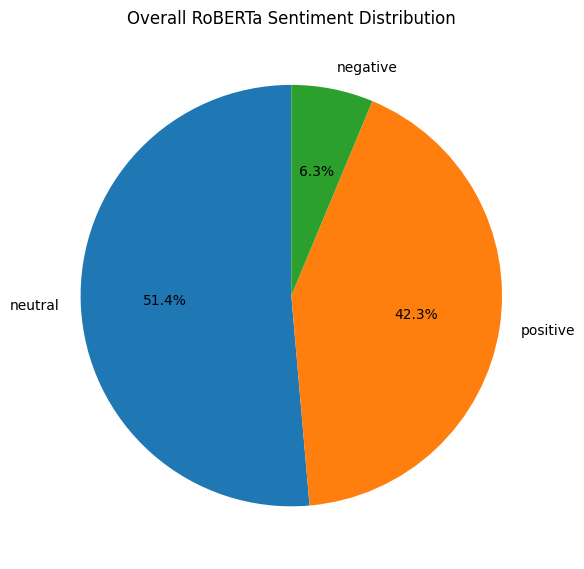

In [ ]:
# --- RoBERTa Distribution Pie Chart ---
roberta_counts = merged_df['roberta_sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(roberta_counts, labels=roberta_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Overall RoBERTa Sentiment Distribution')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

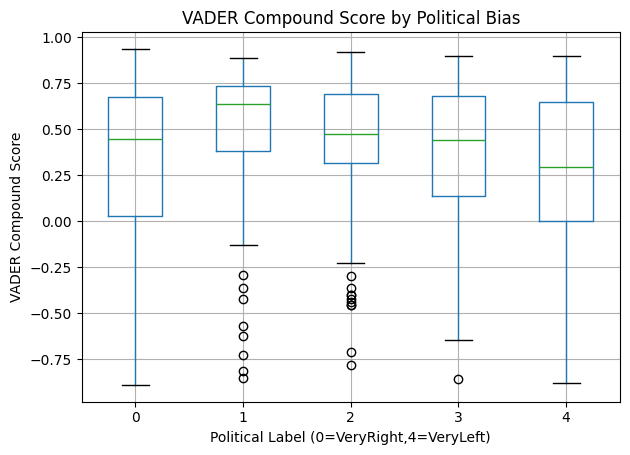

In [ ]:
# --- Analysis by Political Label ---
plt.figure(figsize=(8,6))
merged_df.boxplot(column='vader_compound', by='label')
plt.title('VADER Compound Score by Political Bias')
plt.suptitle('')
plt.xlabel('Political Label (0=VeryRight,4=VeryLeft)')
plt.ylabel('VADER Compound Score')
plt.tight_layout()
plt.show()

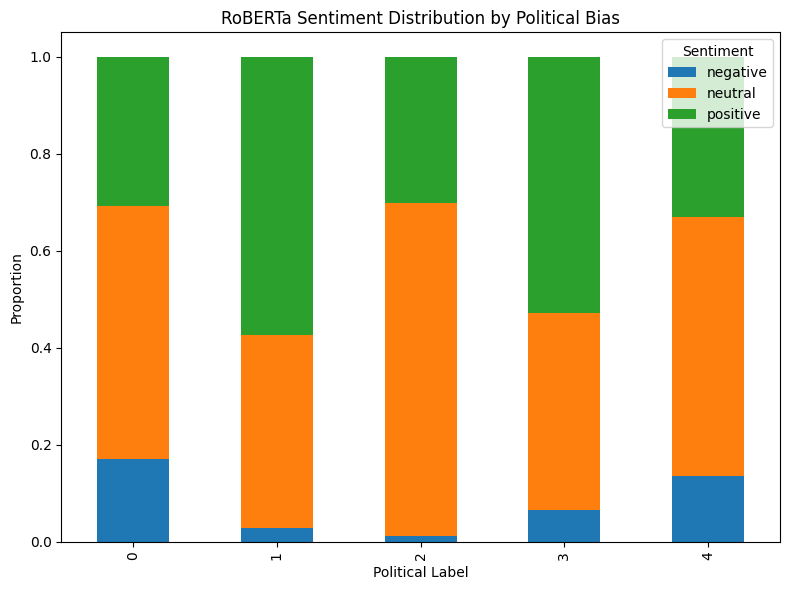

In [ ]:
# RoBERTa label proportions per class
distrib = merged_df.groupby(['label', 'roberta_sentiment']).size().unstack(fill_value=0)
distrib_pct = distrib.div(distrib.sum(axis=1), axis=0)
distrib_pct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('RoBERTa Sentiment Distribution by Political Bias')
plt.xlabel('Political Label')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1) Actual polarity from original labels
#    labels 0–1 → right, 2 → center, 3–4 → left
merged_df['actual_polarity'] = merged_df['label'].apply(
    lambda x: 'right' if x <= 1 else ('left' if x >= 3 else 'center')
)


In [ ]:
# 2) Predicted polarity from VADER
merged_df['pred_polarity_vader'] = merged_df['vader_sentiment'].map({
    'negative': 'right',
    'neutral': 'center',
    'positive': 'left'
})

In [ ]:
# 3) Predicted polarity from RoBERTa
merged_df['pred_polarity_roberta'] = merged_df['roberta_sentiment'].map({
    'negative': 'right',
    'neutral': 'center',
    'positive': 'left'
})

In [ ]:
# 4) Evaluate VADER
print("=== VADER-based Prediction ===")
print("Accuracy:", f"{accuracy_score(merged_df['actual_polarity'], merged_df['pred_polarity_vader']):.3f}")
print("\nClassification Report:\n",
      classification_report(merged_df['actual_polarity'], merged_df['pred_polarity_vader']))

=== VADER-based Prediction ===
Accuracy: 0.318

Classification Report:
               precision    recall  f1-score   support

      center       0.28      0.12      0.17       255
        left       0.32      0.72      0.44       321
       right       0.33      0.08      0.13       331

    accuracy                           0.32       907
   macro avg       0.31      0.31      0.25       907
weighted avg       0.31      0.32      0.25       907



In [ ]:
# 5) Evaluate RoBERTa
print("\n=== RoBERTa-based Prediction ===")
print("Accuracy:", accuracy_score(merged_df['actual_polarity'], merged_df['pred_polarity_roberta']))
print("\nClassification Report:\n",
      classification_report(merged_df['actual_polarity'], merged_df['pred_polarity_roberta']))


=== RoBERTa-based Prediction ===
Accuracy: 0.3748621830209482

Classification Report:
               precision    recall  f1-score   support

      center       0.38      0.69      0.49       255
        left       0.37      0.44      0.40       321
       right       0.40      0.07      0.12       331

    accuracy                           0.37       907
   macro avg       0.38      0.40      0.34       907
weighted avg       0.38      0.37      0.32       907



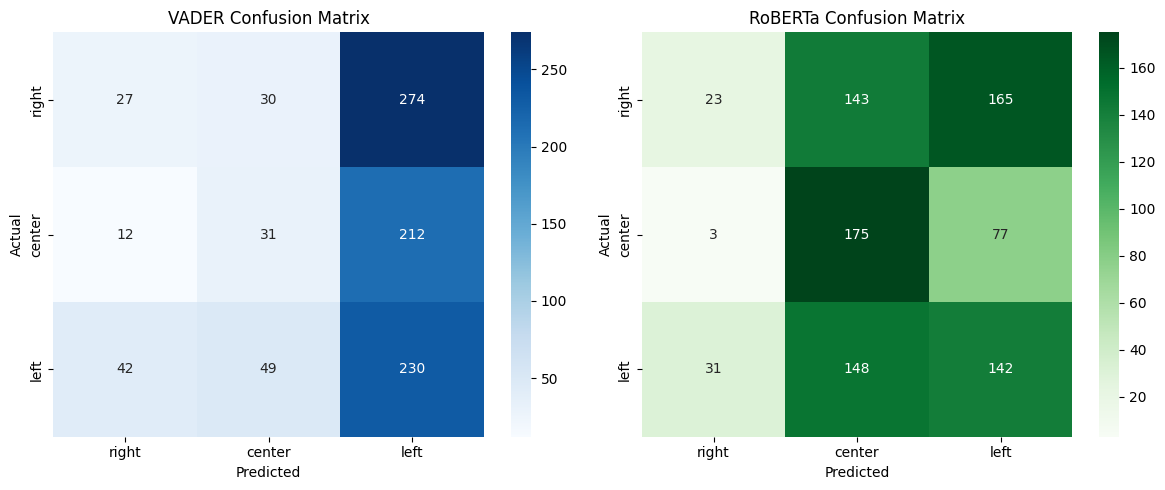

In [ ]:
import seaborn as sns

# Define label order
labels = ['right', 'center', 'left']

# Compute confusion matrices
cm_vader = confusion_matrix(merged_df['actual_polarity'], merged_df['pred_polarity_vader'], labels=labels)
cm_roberta = confusion_matrix(merged_df['actual_polarity'], merged_df['pred_polarity_roberta'], labels=labels)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('VADER Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('RoBERTa Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# ML Classification

In [18]:
# Splitting Data
contents = merged_df['cleaned_content'].fillna('')
labels = merged_df['label']  # integer labels from 0 to 4

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    contents,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [19]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1,2),  # unigrams + bigrams
    min_df=5,
    max_df=0.9,
    stop_words='english'
)
X_train = tfidf.fit_transform(X_train_texts)
X_test  = tfidf.transform(X_test_texts)

In [20]:
# Logistic Regression
evaluations = {}
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best LR params:", grid_search.best_params_)

y_pred_lr = grid_search.predict(X_test)
evaluations['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr, digits=4))

Best LR params: {'C': 1}

Logistic Regression Results:
              precision    recall  f1-score   support

           0     0.3548    0.5789    0.4400        19
           1     0.7895    0.6250    0.6977        48
           2     0.8367    0.8039    0.8200        51
           3     0.6207    0.5000    0.5538        36
           4     0.6000    0.7500    0.6667        28

    accuracy                         0.6648       182
   macro avg     0.6403    0.6516    0.6356       182
weighted avg     0.6948    0.6648    0.6718       182



In [21]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluations['Random Forest'] = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf, digits=4))


Random Forest Results:
              precision    recall  f1-score   support

           0     0.4615    0.6316    0.5333        19
           1     0.7429    0.5417    0.6265        48
           2     0.6667    0.8235    0.7368        51
           3     0.4722    0.4722    0.4722        36
           4     0.7273    0.5714    0.6400        28

    accuracy                         0.6209       182
   macro avg     0.6141    0.6081    0.6018       182
weighted avg     0.6362    0.6209    0.6193       182



In [22]:
# Serializing Logistic Regression
with open("tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(tfidf, f)
with open("lr_model.pkl","wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [23]:
# Advanced Model: Fine-tune BERT / RoBERTa

# Prepare datasets for Hugging Face
train_df = pd.DataFrame({'text': X_train_texts, 'label': y_train})
test_df  = pd.DataFrame({'text': X_test_texts,  'label': y_test})
train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

model_name = 'distilroberta-base'  # or 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [24]:
# Tokenization function
def tokenize_fn(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

In [25]:
# Format for training
target_columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format('torch', columns=target_columns)
test_ds.set_format('torch', columns=target_columns)

In [26]:
# Load model with correct number of labels
num_labels = labels.nunique()  # should be 5 (0-4)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Metrics setup
accuracy = load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

In [28]:
# Enable gradient checkpointing (reduce memory footprint)
model.gradient_checkpointing_enable()

In [29]:
# Training arguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    num_train_epochs=8,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=["none"],
    fp16=True,
    fp16_opt_level="O1"
)

In [30]:
# Trainer setup
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [49]:
# Train & Evaluate
train_result = trainer.train()
eval_result = trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.947550,0.637363


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.947550,0.637363
2,0.349900,0.963726,0.648352
3,0.350100,1.031877,0.637363
4,0.312900,1.053094,0.642857


In [32]:
best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint found at:", best_ckpt)

Best checkpoint found at: ./results/checkpoint-322


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
preds = np.argmax(trainer.predict(test_ds).predictions, axis=1)
print(classification_report(y_test, preds, digits=4))
cm = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0     0.5357    0.7895    0.6383        19
           1     0.8158    0.6458    0.7209        48
           2     0.8367    0.8039    0.8200        51
           3     0.4571    0.4444    0.4507        36
           4     0.5000    0.5714    0.5333        28

    accuracy                         0.6538       182
   macro avg     0.6291    0.6510    0.6327       182
weighted avg     0.6729    0.6538    0.6578       182



# Running Saved Models on tweets

In [34]:
!pip install Mastodon.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.7 MB/s eta 0:00:00


In [35]:
def authenticate_mastodon():
    # Access the variables
    client_id = "_MgdqXghhEiv1m4dpxdn1dFbdNcwKNiWRePv90xnl7E"
    client_secret ="pf1iGO85hkTQ5BiMVVyMyLFpSL7bcaSpR5KubWyk02M"
    access_token ="9K7BkG4Kqts9MKBS-lP21jpNIZEiJOwOT53nRbkNKQE"
    api_base_url ="https://mastodon.social"

    # Authenticate with Mastodon API
    from mastodon import Mastodon
    mastodon = Mastodon(
        client_id=client_id,
        client_secret=client_secret,
        access_token=access_token,
        api_base_url=api_base_url
    )

    print("Authentication successful!")
    return mastodon


mastodon = authenticate_mastodon()

Authentication successful!


In [36]:
def fetch_mastodon_posts():
    # Fetch posts from #politics
    politics_posts = mastodon.timeline_hashtag("politics", limit=100)

    # Convert to a structured format
    data = []
    for post in politics_posts:
        data.append({
            "id": post["id"],
            "created_at": post["created_at"],
            "content": post["content"],
            "account": post["account"]["username"],
            "url": post["url"],
            "language": post["language"]
        })

    # Convert to a DataFrame
    df = pd.DataFrame(data)
    return df

df = fetch_mastodon_posts()
df.reset_index(inplace=True)

In [37]:
def clean_text(html_text):
    text = BeautifulSoup(html_text, "html.parser").get_text()
    text = text.lower().strip()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"[@#]\w+", "", text)       # remove mentions/hashtags
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# Apply cleaning function to the 'content' column
df["cleaned_content"] = df["content"].apply(clean_text)

print(df[["content", "cleaned_content"]].head())

                                             content  \
0  <p>What a great interview with Jacinda Ardern....   
1  <p><a href="https://masto.ai/tags/writer" clas...   
2  <p>Indeed, war will not bring any benefit to a...   
3  <p>Hopefully, if one day Israel recognizes sov...   
4  <p>Thank you to President Prabowo Subianto for...   

                                     cleaned_content  
0  great interview jacinda ardern good reminder e...  
1                                musks drug use link  
2  indeed war bring benefit party yes twostate so...  
3  hopefully one day israel recognizes sovereignt...  
4  thank president prabowo subianto giving signal...  


In [38]:
example = merged_df['cleaned_content'][19]
print(example)

balanced approach immigration benefit economy enrich cultural diversity


In [39]:
# Loading classical pipeline
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)
with open("lr_model.pkl", "rb") as f:
    lr = pickle.load(f)


In [40]:
# Loading Fine-tuned Transformer
model_dir = "./results/checkpoint-184"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
roberta_pipe = pipeline(
    "text-classification",
    model=model_dir,
    tokenizer=tokenizer,
    return_all_scores=False
)


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [41]:
def predict_tweet(text):
    clean = text

    # Classical
    X = tfidf.transform([clean])
    lr_pred = lr.predict(X)[0]
    lr_proba = lr.predict_proba(X)[0]

    # Transformer
    tf_res = roberta_pipe(clean, truncation=True)[0]
    tf_label = int(tf_res["label"].split("_")[-1])
    tf_score = tf_res["score"]

    print(f"Original Tweet: {text}")
    print("—" * 40)
    print(f"Logistic Regression →  Label: {lr_pred}  |  Probabilities: {lr_proba}")
    print(f"RoBERTa Fine-tuned  →  Label: {tf_label}  |  Confidence: {tf_score:.2%}")


In [42]:
predict_tweet(example)

Original Tweet: balanced approach immigration benefit economy enrich cultural diversity
————————————————————————————————————————
Logistic Regression →  Label: 1  |  Probabilities: [0.10329014 0.41581907 0.31928496 0.0733369  0.08826893]
RoBERTa Fine-tuned  →  Label: 2  |  Confidence: 69.93%
